# NYC Taxi dataset - anomaly detection with Autoencoder

### Libraries and settings

In [1]:
# libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed

import warnings

In [2]:
# settings
plt.rcParams['figure.figsize'] = (10, 4)
sns.set()
warnings.filterwarnings('ignore')

### Dataset

```nyc_taxi.csv``` - number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years Day, and a snow storm. The raw data is from the [NYC Taxi and Limousine Commission](https://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). The data consists of aggregating the total number of taxi passengers into 30 minute buckets.

![info](https://raw.githubusercontent.com/bartk97/NYC-Taxi-Anomaly-Detection/main/Images/Data%20with%20highlighted%20anomalies.png)

### Goal
I am going to detect anomalies in the dataset.

### Import data
Importing data from https://github.com/numenta/NAB

In [3]:
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
data = pd.read_csv(url, parse_dates=['timestamp'], index_col='timestamp')
data.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


We can see that the data is split into 30 minute buckets so there are $24\cdot2 = 48$ data points per day.

In [4]:
period = 24 * 2
data.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)

### Some information about the data

In [5]:
print('From  ' + str(np.min(data.index)) + '  to  ' +str(np.max(data.index)))

From  2014-07-01 00:00:00  to  2015-01-31 23:30:00


In [6]:
print('Data size: %d \nNumber of data per day: %d \nNumber of days: %d' %(data.shape[0], period, data.shape[0] / period))

Data size: 10320 
Number of data per day: 48 
Number of days: 215


In [7]:
print('Missing value: ', data.isnull().to_numpy().sum())

Missing value:  0


### Time Series Plot

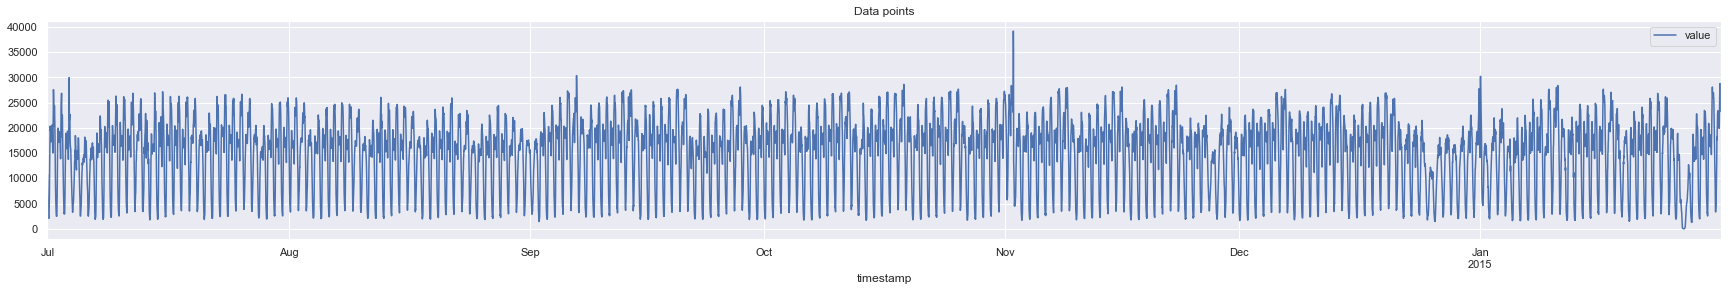

In [8]:
data.plot(title='Data points', figsize=(30,4))
plt.show()

### Plots with the data from first 5 days

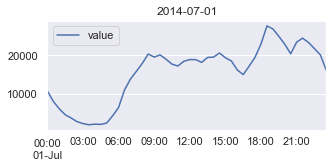

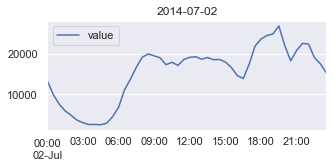

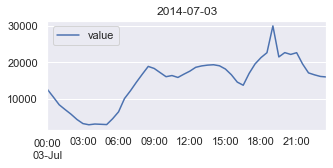

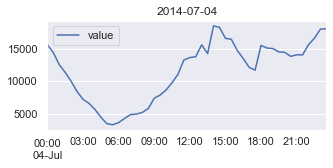

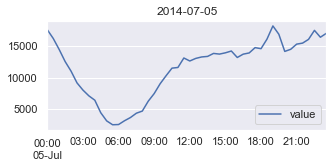

In [9]:
for i in range(5):
    data[period*i:period*(i + 1)].plot(figsize=(5, 2), title=str(data.index[period * i])[:10])
    plt.xlabel(None)
    plt.show()

### Splitting data into days

I split a time series into days and created a new DataFrame as follows: one row corresponds to one day and one column corresponds to 30-minute interval.

In [10]:
# splitting data into days - function
def create_dataset(X, dates, period=1):
    Xs = []
    indexes = []
    for i in range(int(len(X) / period)):
        v = X.iloc[i*period: (i + 1)*period].values
        indexes.append(dates[period*i])
        Xs.append(v)        
    return np.array(Xs), np.array(indexes)

In [11]:
# new data frame
df, dates = create_dataset(data.value, data.index, period)
df = pd.DataFrame(df, dates)

print('df.shape: ', df.shape)
df.head()

df.shape:  (215, 48)


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
2014-07-01,10844,8127,6210,4656,3820,2873,2369,2064,2221,2158,...,26827,24904,22875,20394,23401,24439,23318,21733,20104,16111
2014-07-02,13370,9945,7571,5917,4820,3634,2993,2535,2570,2485,...,24887,26872,22009,18259,20844,22576,22401,19056,17518,15307
2014-07-03,12646,10562,8416,7098,5826,4383,3270,2948,3146,3077,...,29985,21501,22684,22188,22663,19573,17136,16606,16166,16020
2014-07-04,15591,14395,12535,11341,9980,8404,7200,6578,5657,4474,...,14999,14487,14415,13796,14036,14021,15593,16589,17984,18035
2014-07-05,17576,16189,14441,12535,11006,9151,8010,7096,6407,4421,...,18182,16861,14140,14477,15293,15457,16048,17477,16391,17006


### Mean and standard deviation function (w.r.t. hours)

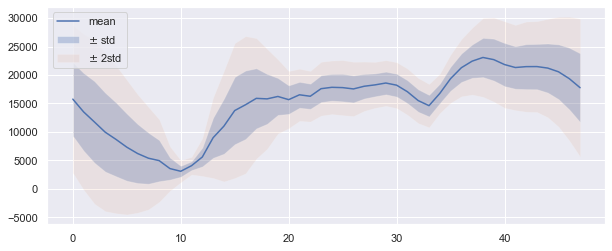

In [12]:
plt.plot(df.mean(), label='mean')
plt.fill_between(df.columns, df.mean() + df.std(), df.mean() - df.std(), alpha=0.3, label='$\pm$ std')
plt.fill_between(df.columns, df.mean() + 2*df.std(), df.mean() - 2*df.std(), alpha=0.1, label= '$\pm$ 2std')
plt.legend()
plt.show()

### Mean and standard deviation function vs Data Points

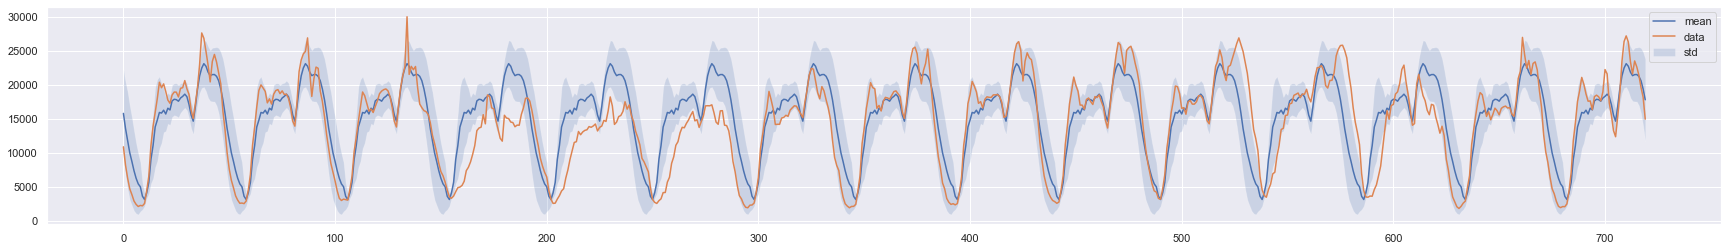

In [13]:
n_days = 15
mean_fucntion = np.tile(df.mean(), n_days)
std_function = np.tile(df.std(), n_days)

plt.figure(figsize=(30, 4))
plt.plot(mean_fucntion, label='mean')
plt.fill_between(np.arange(period*n_days), mean_fucntion - std_function, mean_fucntion + std_function, alpha=0.2, label='std')
plt.plot(data.to_numpy().flatten()[:period*n_days], label='data')
plt.legend()
plt.show()

### Splitting data into train and test sets

In [14]:
# splitting
ratio = 0.55
train_size = int(df.shape[0] * ratio)
X_train = df[:train_size]
X_test = df[train_size:]

dates_train = np.array(df.index[:train_size], dtype='datetime64[D]')
dates_test = np.array(df.index[train_size:], dtype='datetime64[D]')


# info
print('Train size: ', ratio)
print('\n\nTRAIN SET:  from  ' + str(np.min(dates_train)) + '  to  ' +str(np.max(dates_train)))
print('Data size: ', X_train.shape[0])
print('Number of days: ', int(X_train.shape[0] / period))
print('\n\nTEST SET:  from  ' + str(np.min(dates_test)) + '  to  ' +str(np.max(dates_test)))
print('Data size: ', X_test.shape[0])
print('Number of days: ', int(X_test.shape[0] / period))

Train size:  0.55


TRAIN SET:  from  2014-07-01  to  2014-10-26
Data size:  118
Number of days:  2


TEST SET:  from  2014-10-27  to  2015-01-31
Data size:  97
Number of days:  2


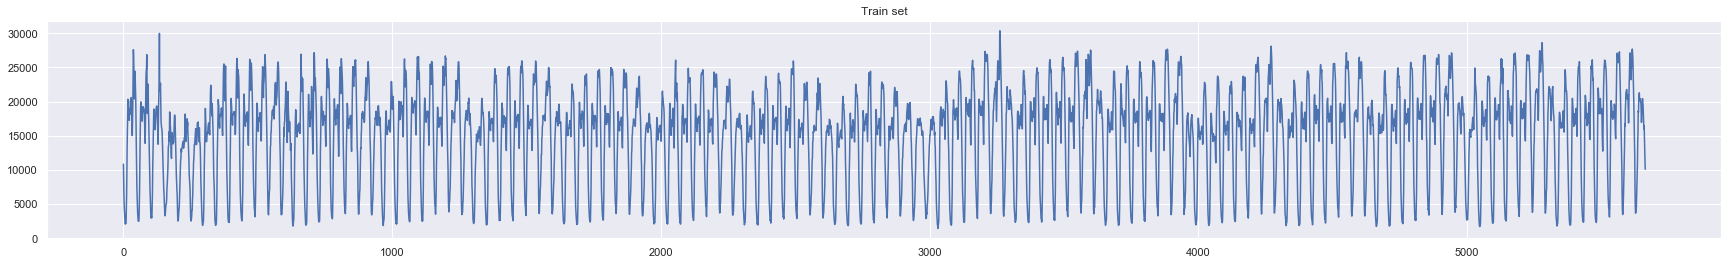

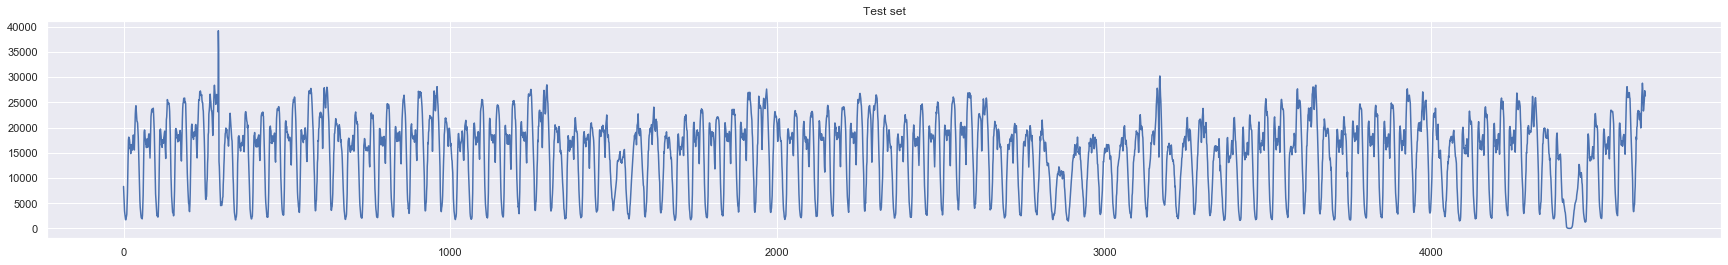

In [15]:
#plots
plt.figure(figsize=(30,4))
plt.title('Train set')
plt.plot(X_train.to_numpy().flatten())
plt.show()

plt.figure(figsize=(30,4))
plt.title('Test set')
plt.plot(X_test.to_numpy().flatten())
plt.show()

We can see that in the test set we have events such as the NYC marathon, Thanksgiving, Christmas, New Years Day, and a snow storm.

### Data standardization
Standardize data by removing the mean and scaling to unit variance.

In [16]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

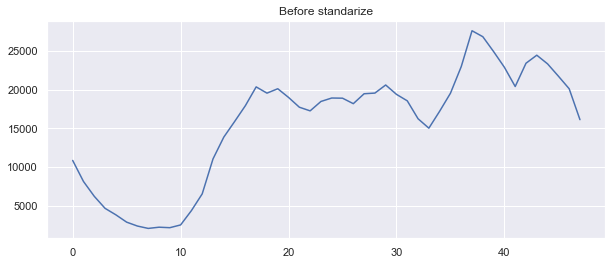

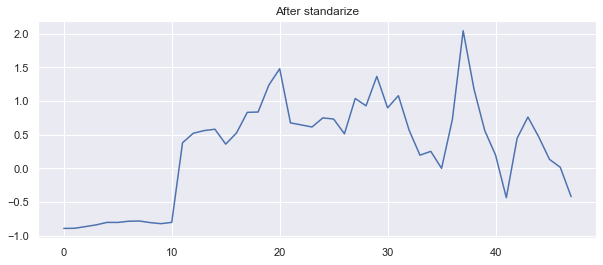

In [17]:
plt.title('Before standarize')
plt.plot(scaler.inverse_transform(X_train[0]))
plt.show()

plt.title('After standarize')
plt.plot(X_train[0])
plt.show()

### Autoencoder

In [18]:
# params
dim_hidden1 = 32
dim_hidden2 = 16
dim_hidden3 = 8


# model
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Sequential([
          Dense(dim_hidden1, activation="relu"),
          Dense(dim_hidden2, activation="relu"),
          Dense(dim_hidden3, activation="relu")])

        self.decoder = Sequential([
          Dense(dim_hidden2, activation="relu"),
          Dense(dim_hidden1, activation="relu"),
          Dense(period, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Fitting model

In [19]:
# params
epochs = 100
batch_size = 20
validation_split = 0.1
shuffle = False


# fitting model
autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X_train, X_train, 
                          epochs = epochs, 
                          batch_size = batch_size, 
                          validation_split = validation_split, 
                          shuffle = shuffle)

Train on 106 samples, validate on 12 samples
Epoch 1/100
106/106 [==============================] - 2s 19ms/sample - loss: 1.2731 - val_loss: 1.0235
Epoch 2/100
106/106 [==============================] - 0s 892us/sample - loss: 1.2663 - val_loss: 1.0142
Epoch 3/100
106/106 [==============================] - 0s 782us/sample - loss: 1.2585 - val_loss: 1.0012
Epoch 4/100
106/106 [==============================] - 0s 839us/sample - loss: 1.2470 - val_loss: 0.9819
Epoch 5/100
106/106 [==============================] - 0s 835us/sample - loss: 1.2284 - val_loss: 0.9553
Epoch 6/100
106/106 [==============================] - 0s 866us/sample - loss: 1.2000 - val_loss: 0.9247
Epoch 7/100
106/106 [==============================] - 0s 777us/sample - loss: 1.1635 - val_loss: 0.8964
Epoch 8/100
106/106 [==============================] - 0s 754us/sample - loss: 1.1230 - val_loss: 0.8745
Epoch 9/100
106/106 [==============================] - 0s 717us/sample - loss: 1.0825 - val_loss: 0.8602
Epoch 10/10

### Training and Validation Loss

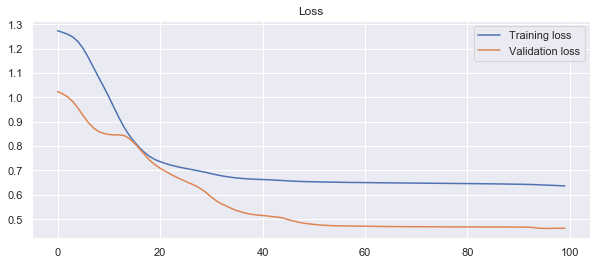

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

### Reconstruction example on a training set


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



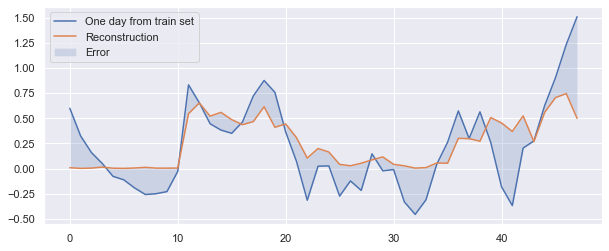

Error (MSE):  0.0978950936630301


In [21]:
encoded_data = autoencoder.encoder(X_train).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

i = 10

plt.plot(X_train[i], label='One day from train set')
plt.plot(decoded_data[i], label='Reconstruction')
plt.fill_between(np.arange(48), decoded_data[i], X_train[i], alpha=0.2, label='Error')
plt.legend()
plt.show()

print('Error (MSE): ',np.mean((X_train[i] - decoded_data[i])**2))

### Reconstruction example on a test set

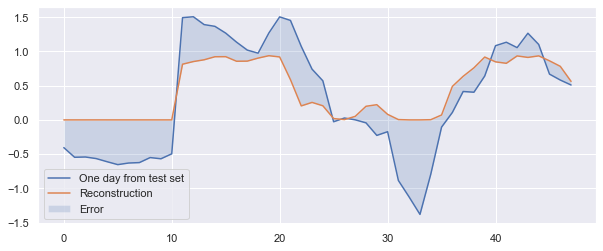

Error (MSE):  0.2747881460319304


In [22]:
encoded_data = autoencoder.encoder(X_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

i = 10

plt.plot(X_test[i], label='One day from test set')
plt.plot(decoded_data[i], label='Reconstruction')
plt.fill_between(np.arange(48), decoded_data[i], X_test[i], alpha=0.2, label='Error')
plt.legend()
plt.show()

print('Error (MSE): ',np.mean((X_test[i] - decoded_data[i])**2))

### Loss distribution - Training set

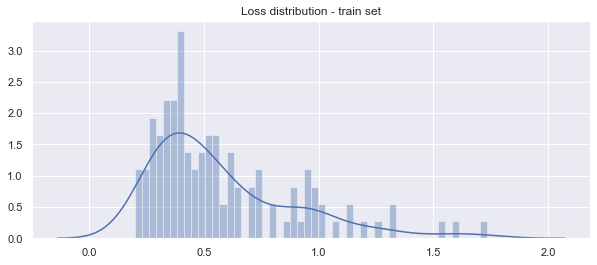

In [23]:
reconstruction = autoencoder.predict(X_train)
loss_train = tf.keras.losses.mae(reconstruction, X_train)

plt.title('Loss distribution - train set')
sns.distplot(loss_train, bins=50, kde=True)
plt.show()

### Loss distribution - Test set

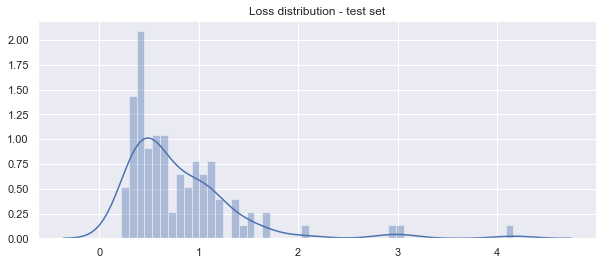

In [24]:
reconstruction_test = autoencoder.predict(X_test)
loss_test = tf.keras.losses.mae(reconstruction_test, X_test)

plt.title('Loss distribution - test set')
sns.distplot(loss_test, bins=50, kde=True)
plt.show()

### Selection Threshold

threshold = mean of the loss + 2 standard devation of the loss

In [25]:
# threshold = np.quantile(loss_train, 0.95)
threshold = np.mean(loss_train) + 2*np.std(loss_train)
print(threshold)

1.2115754439956914


### Loss for each day of the test set vs Threshold

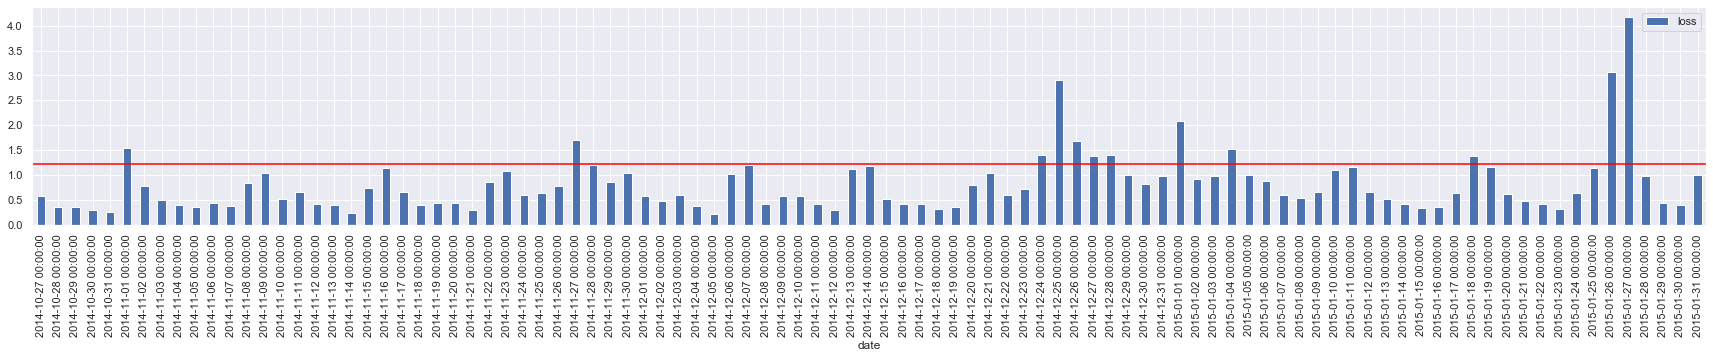

In [26]:
results = pd.DataFrame({'date': np.array(dates_test, dtype='datetime64[D]'), 
                        'loss': loss_test})

results = results.set_index('date')

results.plot(kind='bar', figsize=(30,4))
plt.axhline(threshold, color='red', label='threshold')
plt.show()

### Detected anomalies

In [27]:
scaled_loss = (loss_test - np.min(loss_test)) / (np.max(loss_test) - np.min(loss_test)) * 0.4

In [28]:
y_pred = loss_test.numpy() >= threshold

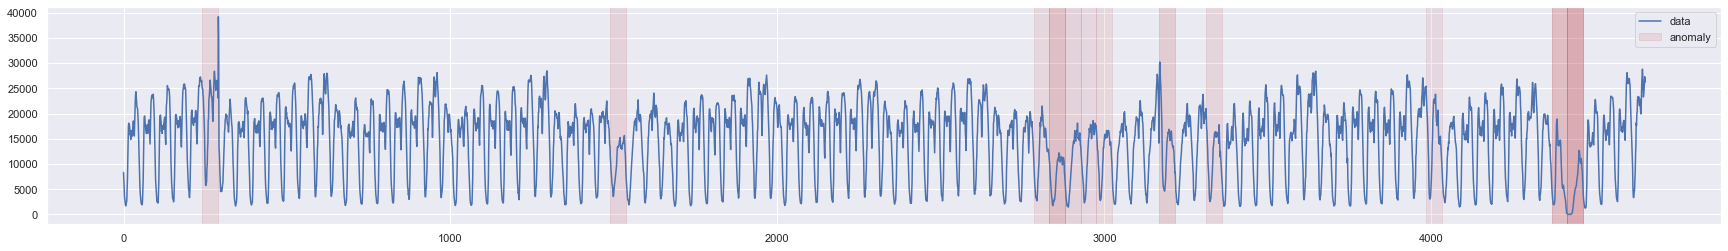

In [29]:
plt.figure(figsize=(30,4))
for i in np.arange(y_pred.shape[0])[y_pred]:
    plt.axvspan(i*48, (i + 1)*48, color='r',alpha=scaled_loss[i])
plt.plot(scaler.inverse_transform(X_test).flatten())
plt.legend(['data', 'anomaly'])
plt.show()

In [30]:
print(np.array(dates_test[y_pred]))

['2014-11-01' '2014-11-27' '2014-12-24' '2014-12-25' '2014-12-26'
 '2014-12-27' '2014-12-28' '2015-01-01' '2015-01-04' '2015-01-18'
 '2015-01-26' '2015-01-27']


Most of the detected anomalies  match the following events:
* [NYC Marathon](https://en.wikipedia.org/wiki/2014_New_York_City_Marathon) (02.11.2014)
* Thanksgiving (27.11.2014)
* Christmas (24-26.12.2014)
* New Years Day (01.01.2015)
* [January 2015 North American blizzard](https://en.wikipedia.org/wiki/January_2015_North_American_blizzard) (26-27.01.2015)

![image info](https://raw.githubusercontent.com/bartk97/NYC-Taxi-Anomaly-Detection/main/Images/Data%20with%20highlighted%20anomalies.png)

### Plots of detected anomalies

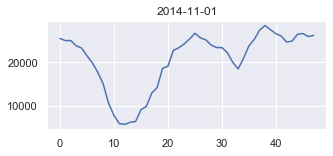

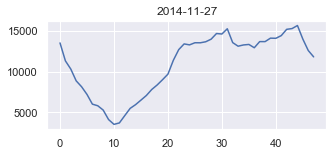

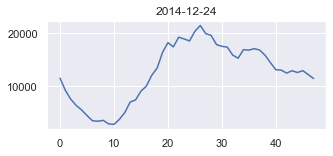

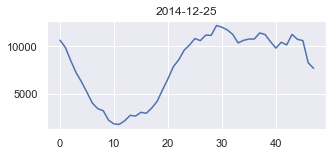

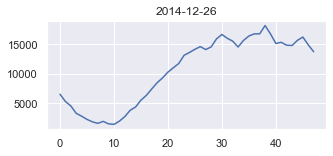

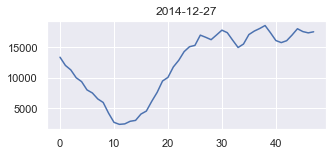

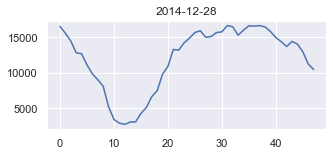

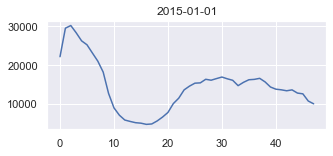

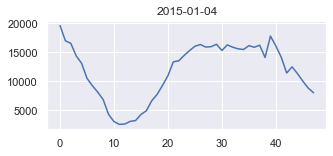

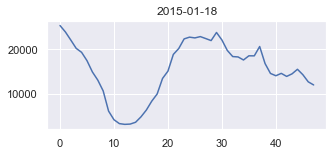

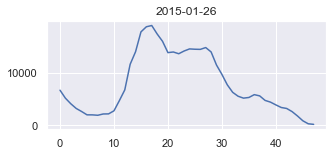

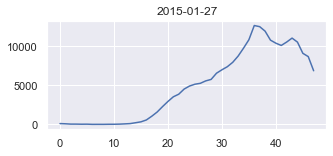

In [31]:
for d, x in zip(np.array(dates_test[y_pred]), scaler.inverse_transform(X_test)[y_pred]):
    plt.figure(figsize=(5,2))
    plt.title(d)
    plt.plot(x)
    plt.show()